In [59]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_ollama.chat_models import ChatOllama
from pydantic import BaseModel, Field
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import OllamaEmbeddings
import chromadb
import pandas as pd
from pprint import pprint
from IPython.display import Image, display

## LLM & VectorDB 

In [60]:
def get_semantic_search_docs(query:str, vectorstore, k:int=100, fetch_k:int=200):
    retriever = vectorstore.as_retriever(
        search_type="mmr", 
        search_kwargs={'k': 100, "fetch_k":200}
        )
    result = retriever.invoke(query)
    return result

import re
import numpy as np
from rank_bm25 import BM25Okapi

def get_bm25_top_docs(query:str, documents:list, top_k:int=20):

    tokenized_corpus = [doc.page_content for doc in documents]
    bm25 = BM25Okapi(tokenized_corpus)

    pattern = r'"(.*?)"'  # 따옴표로 둘러싸인 단어만 검색 대상으로 리스트에 담기
    extracted_keywords = re.findall(pattern, query)
    doc_scores = bm25.get_scores(extracted_keywords)

    sorted_indices = np.argsort(doc_scores)  # 값에 대한 정렬된 인덱스
    order_values = np.empty_like(sorted_indices)
    order_values[sorted_indices] = np.arange(len(doc_scores))

    top_index = [i for i, value in enumerate(order_values) if value < top_k]
    top_docs = [i for i in documents if documents.index(i) in top_index ]
    return top_docs

def get_keywords_matched_docs(query:str, documents:list, and_condition:bool=True):
    pattern = r'"(.*?)"'  # 따옴표로 둘러싸인 단어만 검색 대상으로 리스트에 담기
    extracted_keywords = re.findall(pattern, query)
    lower_keywors = [keyword.lower() for keyword in extracted_keywords]

    lower_docs = [doc.page_content.lower() for doc in documents]
    if and_condition: matching_sentences = [sentence for sentence in lower_docs if all(keyword in sentence for keyword in lower_keywors)]
    else: matching_sentences = [sentence for sentence in lower_docs if any(keyword in sentence for keyword in lower_keywors)]

    matched_index = [lower_docs.index(doc) for doc in matching_sentences]
    final_matched_docs = [documents[i] for i in matched_index]

    return final_matched_docs

In [16]:
llm = ChatGroq(temperature=0, model_name= "llama-3.2-11b-text-preview")
# llm = ChatOllama(base_url="http://localhost:11434", model="llama3.2:latest")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001BC4B880380>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001BC4B880890>, model_name='llama-3.2-11b-text-preview', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [53]:
%timeit
db_path = "./db/chroma_db_02"
vectorstore = Chroma(collection_name="collection_01", persist_directory=db_path, embedding_function=OllamaEmbeddings(model="bge-m3:latest"))
query = 'according to "iss" manual, what is the "noon report" in iss system?'
result = vectorstore.similarity_search_with_relevance_scores(query=query, k=3)
result

[(Document(metadata={'File Name': '370_RULES FOR THE AUDIT AND REGISTRATION OF SHIP SECURITY MANAGEMENT SYSTEMS_202406', 'File Path': '/content/drive/MyDrive/Rules/NK/370_RULES FOR THE AUDIT AND REGISTRATION OF SHIP SECURITY MANAGEMENT SYSTEMS_202406.pdf', 'First Division': 'Rules', 'Page': 10, 'Second Division': 'NK'}, page_content='This page explains 370_RULES FOR THE AUDIT AND REGISTRATION OF SHIP SECURITY MANAGEMENT SYSTEMS_202406, that belongs to catogories of Rules and NK./nto carry out any activities required by Chapter XI -2 of SOLAS  and ISPS Code Part A . (2) “Date of ISPS registration” means the date of the last day of the Initial Audit prescribed in 3.3.1 -1 of the Rules. However, when the Audit for issuing the Interim ISSC prescribed in 3.5-1(1) of the Rules is carried out in advance of the Initial Audit, it means the date of the last day of the Audit for issuing the Interim ISSC.  (3) “Ship security assessment” means an assessment of the risks of security incident around 

In [18]:
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={'k': 3, "fetch_k":5})
retriever.invoke(query)

[Document(metadata={'File Name': '370_RULES FOR THE AUDIT AND REGISTRATION OF SHIP SECURITY MANAGEMENT SYSTEMS_202406', 'File Path': '/content/drive/MyDrive/Rules/NK/370_RULES FOR THE AUDIT AND REGISTRATION OF SHIP SECURITY MANAGEMENT SYSTEMS_202406.pdf', 'First Division': 'Rules', 'Page': 10, 'Second Division': 'NK'}, page_content='This page explains 370_RULES FOR THE AUDIT AND REGISTRATION OF SHIP SECURITY MANAGEMENT SYSTEMS_202406, that belongs to catogories of Rules and NK./nto carry out any activities required by Chapter XI -2 of SOLAS  and ISPS Code Part A . (2) “Date of ISPS registration” means the date of the last day of the Initial Audit prescribed in 3.3.1 -1 of the Rules. However, when the Audit for issuing the Interim ISSC prescribed in 3.5-1(1) of the Rules is carried out in advance of the Initial Audit, it means the date of the last day of the Audit for issuing the Interim ISSC.  (3) “Ship security assessment” means an assessment of the risks of security incident around s

In [19]:
def read_vectordb_as_df(db_path:str):
    client = chromadb.PersistentClient(path=db_path)
    for collection in client.list_collections():
        data = collection.get(include=['embeddings', 'documents', 'metadatas'])
        df = pd.DataFrame({"ids":data["ids"], 
                            "metadatas":data["metadatas"], 
                            "documents":data["documents"]})
        df["first_div"] = df["metadatas"].apply(lambda x: x["First Division"])
        df["second_div"] = df["metadatas"].apply(lambda x: x["Second Division"])
        df["filename"] = df["metadatas"].apply(lambda x: x["File Name"])
        df = df[["ids", "first_div", "second_div","filename","documents", "metadatas"]]
    return df

df = read_vectordb_as_df(db_path=db_path)
df.head()

,ids,first_div,second_div,filename,documents,metadatas
0,faace8c4-ab2c-43b4-9b4e-7fc15319bc78,MANUAL,Common,[KISA Insight 2023 Vol.03] ChatGPT(챗GPT) 보ᄋ...,This page explains [KISA Insight 2023 Vol.03] ...,{'File Name': '[KISA Insight 2023 Vol.03] Chat...
1,1a3d1b93-e5d3-4a96-990d-e4ba6b976e29,MANUAL,Common,[KISA Insight 2023 Vol.03] ChatGPT(챗GPT) 보ᄋ...,This page explains [KISA Insight 2023 Vol.03] ...,{'File Name': '[KISA Insight 2023 Vol.03] Chat...
2,f67ce384-3df7-4ffe-aa13-9d187d73cb13,MANUAL,Common,[KISA Insight 2023 Vol.03] ChatGPT(챗GPT) 보ᄋ...,This page explains [KISA Insight 2023 Vol.03] ...,{'File Name': '[KISA Insight 2023 Vol.03] Chat...
3,5f7bdc1f-deb2-4f3d-9afb-2eafbf5d5192,MANUAL,Common,[KISA Insight 2023 Vol.03] ChatGPT(챗GPT) 보ᄋ...,This page explains [KISA Insight 2023 Vol.03] ...,{'File Name': '[KISA Insight 2023 Vol.03] Chat...
4,5edec5fa-fdde-41e4-a688-b77fb1fb75c3,MANUAL,Common,[KISA Insight 2023 Vol.03] ChatGPT(챗GPT) 보ᄋ...,This page explains [KISA Insight 2023 Vol.03] ...,{'File Name': '[KISA Insight 2023 Vol.03] Chat...


In [20]:
def get_first_div(db_path:str):
    df = read_vectordb_as_df(db_path=db_path)
    docs_list = df["first_div"].unique().tolist()
    docs_list.sort()
    return docs_list

def get_second_div(db_path:str):
    df = read_vectordb_as_df(db_path=db_path)
    docs_list = df["second_div"].unique().tolist()
    docs_list.sort()
    return docs_list

rag_target1 = get_first_div(db_path=db_path)
rag_target2 = get_second_div(db_path=db_path)
rag_target = rag_target1 + rag_target2
rag_target

['MANUAL',
 'PORT',
 'Rules',
 'ABS',
 'BV',
 'Common',
 'Cryostar',
 'DNV',
 'Integrated Smart Ship(ISS)',
 'KR',
 'LR',
 'MARPOL',
 'NK',
 'Port Regulation',
 'SOLAS',
 'Win GD']

In [21]:
rag_target.insert(0, "vectorstore")
rag_target.insert(0, "vectordb")
docs = ", ".join(rag_target)
docs

'vectordb, vectorstore, MANUAL, PORT, Rules, ABS, BV, Common, Cryostar, DNV, Integrated Smart Ship(ISS), KR, LR, MARPOL, NK, Port Regulation, SOLAS, Win GD'

## Router

In [22]:
# Data model for Structured LLM
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search", "database"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore or a database.",
    )

# Prompt
system = f"""You are an expert at routing a user question to a vectorstore, web search or database.
The vectorstore contains documents related to {docs}.
Use the vectorstore for questions on these topics. 
The question contains words related to database.
Use the database for questions on these topics. 
Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
route_prompt

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are an expert at routing a user question to a vectorstore, web search or database.\nThe vectorstore contains documents related to vectordb, vectorstore, MANUAL, PORT, Rules, ABS, BV, Common, Cryostar, DNV, Integrated Smart Ship(ISS), KR, LR, MARPOL, NK, Port Regulation, SOLAS, Win GD.\nUse the vectorstore for questions on these topics. \nThe question contains words related to database.\nUse the database for questions on these topics. \nOtherwise, use web-search.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='{question}'), additional_kwargs={})])

In [23]:
structured_llm_router = llm.with_structured_output(RouteQuery)
question_router = route_prompt | structured_llm_router
question_router

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are an expert at routing a user question to a vectorstore, web search or database.\nThe vectorstore contains documents related to vectordb, vectorstore, MANUAL, PORT, Rules, ABS, BV, Common, Cryostar, DNV, Integrated Smart Ship(ISS), KR, LR, MARPOL, NK, Port Regulation, SOLAS, Win GD.\nUse the vectorstore for questions on these topics. \nThe question contains words related to database.\nUse the database for questions on these topics. \nOtherwise, use web-search.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='{question}'), additional_kwargs={})])
| RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001BC4B880380>, async_c

In [24]:
%timeit
# print(question_router.invoke({"question": "what is eda?"}))
# print(question_router.invoke({"question": "according to vectorstore, what is eda?"}))
# print(question_router.invoke({"question": "according to rule, what is eda?"}))  # 살짝 다르게
# print(question_router.invoke({"question": "according to menual, what is eda?"}))  # 일부러 오타
# print(question_router.invoke({"question": "summaize RESOLUTION MEPC.248(66) with reference to rules"}))
print(question_router.invoke({"question": "who is Son Heung-min"}))
print(question_router.invoke({"question": "according to database, who is Son Heung-min"}))
print(question_router.invoke({"question": "according to vectordb, who is Son Heung-min"}))

datasource='web_search'
datasource='database'
datasource='vectorstore'


In [25]:
# question = "according to lr rule, explain about ships with installed process plant for chemicals"
question = query
print(question_router.invoke({"question": question}))

datasource='vectorstore'


# Retrieval

In [31]:
%timeit
docs = get_semantic_search_docs(query=query, vectorstore=vectorstore, k=100, fetch_k=200)
print(len(docs))
docs = get_bm25_top_docs(query=query, documents=result, top_k=20)
print(len(docs))
docs = get_keywords_matched_docs(query=query, documents=result, and_condition=True)
print(len(docs))
docs

100
1
1


[Document(metadata={'File Name': 'Integrated Smart Ship(ISS1.0)', 'File Path': '/content/drive/MyDrive/MANUAL/Integrated Smart Ship(ISS)/Integrated Smart Ship(ISS1.0).pdf', 'First Division': 'MANUAL', 'Page': 63, 'Second Division': 'Integrated Smart Ship(ISS)'}, page_content='This page explains Integrated Smart Ship(ISS1.0), that belongs to catogories of MANUAL and Integrated Smart Ship(ISS)./nAPPENDIX     63  "Comparison" button ( Area ② of Figure 64 ). The "Comparison" button, as illustrated in Figure 65, provides functionality to compare the sensor data values before the changes and the values modified by the ISS user.   Figure 64. Noon Report Confirm   Figure 65. Noon Report Comparison  Finally, there is a characteristic of issuing the Noon Report at noon, which entails the possibility of entering data values measured from the ship\'s sensors into the report. The scenarios are as follows:  1. 00:00 ~ 12:00 : Enter real -time ship sensor data in to the report. (Applies to both the i

In [ ]:
# %timeit
# docs = retriever.invoke(question)
# docs

## Retrieval Grader

In [32]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [33]:
structured_llm_grader = llm.with_structured_output(GradeDocuments)
retrieval_grader = grade_prompt | structured_llm_grader
retrieval_grader

ChatPromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are a grader assessing relevance of a retrieved document to a user question. \n \n    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n\n    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n\n    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, template='Retrieved document: \n\n {document} \n\n User question: {question}'), additional_kwargs={})])
| RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001BC4B88

In [34]:
doc_txt = docs[0].page_content
result = retrieval_grader.invoke({"question": question, "document": doc_txt})
result.binary_score

'yes'

In [35]:
%timeit
grade_no_docs = [doc for doc in docs if retrieval_grader.invoke({"question": question, "document": doc}).binary_score == 'no']
grade_no_docs

[]

In [36]:
%timeit
grade_yes_docs = [doc for doc in docs if retrieval_grader.invoke({"question": question, "document": doc}).binary_score == 'yes']
grade_yes_docs

[Document(metadata={'File Name': 'Integrated Smart Ship(ISS1.0)', 'File Path': '/content/drive/MyDrive/MANUAL/Integrated Smart Ship(ISS)/Integrated Smart Ship(ISS1.0).pdf', 'First Division': 'MANUAL', 'Page': 63, 'Second Division': 'Integrated Smart Ship(ISS)'}, page_content='This page explains Integrated Smart Ship(ISS1.0), that belongs to catogories of MANUAL and Integrated Smart Ship(ISS)./nAPPENDIX     63  "Comparison" button ( Area ② of Figure 64 ). The "Comparison" button, as illustrated in Figure 65, provides functionality to compare the sensor data values before the changes and the values modified by the ISS user.   Figure 64. Noon Report Confirm   Figure 65. Noon Report Comparison  Finally, there is a characteristic of issuing the Noon Report at noon, which entails the possibility of entering data values measured from the ship\'s sensors into the report. The scenarios are as follows:  1. 00:00 ~ 12:00 : Enter real -time ship sensor data in to the report. (Applies to both the i

## Generate

In [37]:
# Prompt   (rlm/rag-prompt)
from langchain import hub
prompt = ChatPromptTemplate.from_messages([
    ("human", 
    """You are a knowledgable shipbuilding engineer for technical question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. 
    Generate detailed answer including specified numbers, fomulas in the point of technical specifications. 
    If you don't know the answer, just say that you don't know. 
    Question: {question} 
    Context: {context} 
    Answer:"""),
    ])
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are a knowledgable shipbuilding engineer for technical question-answering tasks. \n    Use the following pieces of retrieved context to answer the question. \n    Generate detailed answer including specified numbers, fomulas in the point of technical specifications. \n    If you don't know the answer, just say that you don't know. \n    Question: {question} \n    Context: {context} \n    Answer:"), additional_kwargs={})])

In [38]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# pprint(len(grade_yes_docs))
# docs = format_docs(docs)
# pprint(docs)

In [39]:
%timeit
rag_chain = prompt | llm | StrOutputParser()
generation = rag_chain.invoke({"context": grade_yes_docs, "question": question})
print(generation)

According to the "ISS" manual, the "Noon Report" in the "ISS System" refers to a report that is issued at noon, which entails the possibility of entering data values measured from the ship's sensors into the report.

The report can be entered in real-time from 00:00 to 12:00, and it applies to both the initial and modified data values. This means that the ISS user can enter the sensor data values before the changes and the values modified by the ISS user.

In terms of technical specifications, the Noon Report can be considered as a data entry process that involves the following steps:

1. Data collection: The ship's sensors collect data from 00:00 to 12:00.
2. Data entry: The ISS user enters the collected data into the report.
3. Data comparison: The ISS system provides a comparison functionality to compare the sensor data values before the changes and the values modified by the ISS user.

The Noon Report can be used to track and record the ship's sensor data values at noon, which can 

## Hallucination Grader

In [40]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [41]:
%timeit
structured_llm_grader = llm.with_structured_output(GradeHallucinations)
hallucination_grader = hallucination_prompt | structured_llm_grader
result = hallucination_grader.invoke({"documents": docs, "generation": generation})
print(result)

binary_score='yes'


## Answer Grader

In [42]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""
    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

In [43]:
%timeit
structured_llm_grader = llm.with_structured_output(GradeAnswer)
answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

## Question Re-Writer

In [56]:
# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)
%timeit
question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Here\'s an improved version of the question optimized for vectorstore retrieval:\n\n"What is the definition of \'noon report\' in the context of ISS (International Space Station) system, as per the ISS manual documentation?"\n\nThis improved question:\n\n1. Uses more specific and descriptive terms like "definition" and "context" to capture the semantic intent.\n2. Includes the acronym "ISS" to disambiguate the search space.\n3. Specifies the source of the information ("ISS manual documentation") to help the vectorstore retrieve relevant documents.\n4. Uses a more formal and structured language to make it easier for the vectorstore to understand the question.\n\nThis reformulation should help the vectorstore retrieve more accurate and relevant results.'

## Web Search Tool

In [44]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)
web_search_tool

TavilySearchResults(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))

## Construct Graph

In [45]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[str]

In [ ]:
from langchain.schema import Document
# Nodes

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    # documents = retriever.invoke(question)
    # print(documents)
    documents = get_semantic_search_docs(query=query, vectorstore=vectorstore, k=100, fetch_k=200)
    documents = get_bm25_top_docs(query=query, documents=result, top_k=20)
    documents = get_keywords_matched_docs(query=query, documents=result, and_condition=True)
    documents
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## Compile Graph

In [47]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)


from langgraph.checkpoint.memory import MemorySaver
### Adding Memory
memory = MemorySaver()
memory

# Compile
# app = workflow.compile(checkpointer=memory)
app = workflow.compile()
app

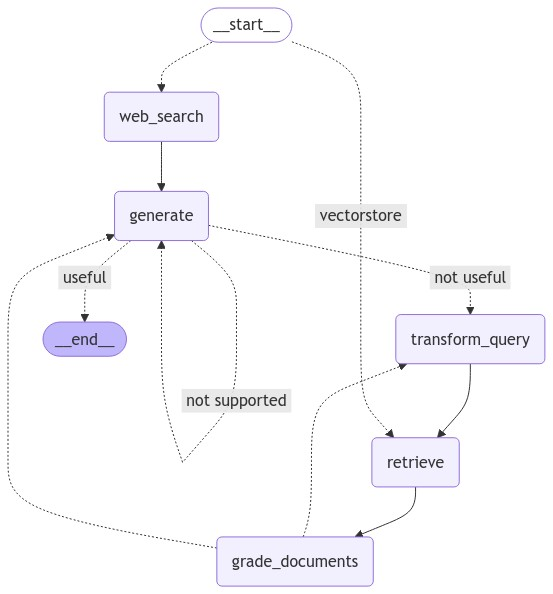

In [48]:
display(Image(app.get_graph().draw_mermaid_png(), width=300))

# App Stream

In [54]:
query = query
query

'according to "iss" manual, what is the "noon report" in iss system?'

In [57]:
from pprint import pprint
from langgraph.errors import GraphRecursionError
%timeit
# Run
# query = """
# what is the obligation of master of troubled vessel in "singapore" "port"
# """
inputs = {
    "question": query, 
    # "max_retrieve": 1,
    
}
config = {
    "recursion_limit": 30, 
    # "configurable": {"thread_id": "1"}
    }
try:
    for output in app.stream(inputs, 
                            config, 
                            #  stream_mode="values"
                            ):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
        pprint("="*70)

    # Final generation
    print("")
    pprint(value)
except GraphRecursionError:
    print("Recursion Error")

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
[Document(metadata={'File Name': '370_RULES FOR THE AUDIT AND REGISTRATION OF SHIP SECURITY MANAGEMENT SYSTEMS_202406', 'File Path': '/content/drive/MyDrive/Rules/NK/370_RULES FOR THE AUDIT AND REGISTRATION OF SHIP SECURITY MANAGEMENT SYSTEMS_202406.pdf', 'First Division': 'Rules', 'Page': 10, 'Second Division': 'NK'}, page_content='This page explains 370_RULES FOR THE AUDIT AND REGISTRATION OF SHIP SECURITY MANAGEMENT SYSTEMS_202406, that belongs to catogories of Rules and NK./nto carry out any activities required by Chapter XI -2 of SOLAS  and ISPS Code Part A . (2) “Date of ISPS registration” means the date of the last day of the Initial Audit prescribed in 3.3.1 -1 of the Rules. However, when the Audit for issuing the Interim ISSC prescribed in 3.5-1(1) of the Rules is carried out in advance of the Initial Audit, it means the date of the last day of the Audit for issuing the Interim ISSC.  (3) “Ship security assessment

KeyboardInterrupt: 

In [45]:
print(value['generation'])

Based on the provided context from the Lloyd's Register Rules and Regulations for the Classification of Ships, July 2022, ships with integrated chemical processing facilities need to comply with the following specific requirements and regulations:

1. **Hull Structural Requirements**: Category 3 ships require additional hull structural requirements to enable them to be satisfactorily grounded (LR, page 1650).
2. **Process Plant Arrangements**:
	* Arrangements for preventing water ingress into the ship or structure where process plant and equipment protrude through the weather deck (LR, page 1648).
	* Proposed emergency flooding procedures and their control (LR, page 1649).
	* Particulars of proposed storage arrangements of hazardous and/or toxic substances, feedstocks, and products in bulk on the ship or structure (LR, page 1649).
3. **Process Plant Design**:
	* Description of the expected method of operation of the process plant and a diagram showing the process flow (LR, page 1649).
